# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.453013,False,-1.890827
1,0.402817,True,6.677771
2,-1.615857,False,-2.637336
3,-0.306609,False,-0.773336
4,-1.898913,False,-4.519044
...,...,...,...
995,-0.955330,False,-1.318309
996,-0.935670,True,3.510639
997,-0.260911,True,4.047119
998,-1.590662,True,2.506465


<AxesSubplot: xlabel='v0'>

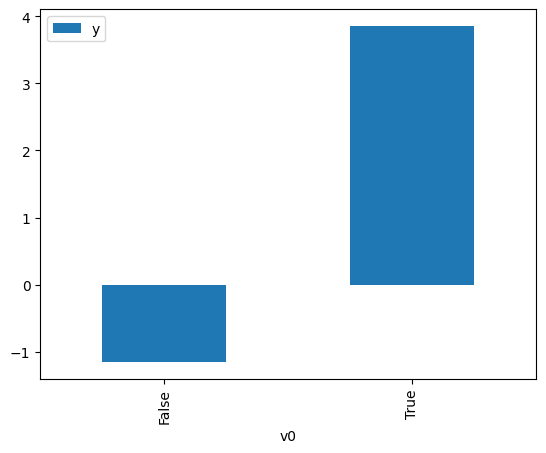

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

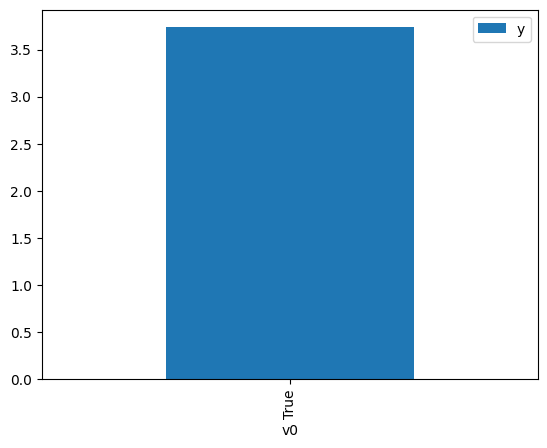

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.605227,False,-3.531181,0.845987,1.182051
1,-1.986484,False,-4.318326,0.893134,1.119653
2,-1.490823,False,-4.281680,0.828854,1.206484
3,-0.253076,False,-2.043474,0.553546,1.806534
4,-0.795559,False,-1.954211,0.692573,1.443890
...,...,...,...,...,...
995,0.353645,False,2.629057,0.388677,2.572827
996,-0.894526,False,-2.080368,0.715271,1.398072
997,-1.071025,False,-1.852636,0.753137,1.327780
998,-0.076214,False,0.253908,0.505079,1.979888


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-3.063091,True,-3.940196,0.035288,28.338476
1,-1.358571,True,2.064057,0.192796,5.186838
2,-1.808687,True,0.783458,0.127035,7.871876
3,-0.941449,True,4.636971,0.274328,3.645273
4,-0.227126,True,3.986623,0.453524,2.204956
...,...,...,...,...,...
995,-1.600050,True,2.438220,0.154757,6.461745
996,-0.944454,True,2.845245,0.273670,3.654040
997,-0.896780,True,3.568128,0.284224,3.518347
998,-0.466780,True,3.666403,0.389300,2.568712


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.944
Model:                            OLS   Adj. R-squared (uncentered):              0.944
Method:                 Least Squares   F-statistic:                              8399.
Date:                Tue, 06 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:37:40   Log-Likelihood:                         -1431.1
No. Observations:                1000   AIC:                                      2866.
Df Residuals:                     998   BIC:                                      2876.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.3793      0.030     79.885      0.000       2.321       2.438
x2             5.0083      0.050    100.181      0.000       4.910       5.106
==============================================================================
Omnibus:                        6.008   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.050   Jarque-Bera (JB):                5.285
Skew:                           0.113   Prob(JB):                       0.0712
Kurtosis:                       2.725   Cond. No.                         1.68
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""